# 1. Ï†ÑÏ≤òÎ¶¨ Î∞è Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

In [135]:
import numpy as np
import pandas as pd   
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# Í≤∞Ï∏°Ïπò Ïª¨Îüº Ï†úÍ±∞
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area Í¥ÄÎ†® Î≥ÄÏàò Ï†úÍ±∞
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# Ïò§ÌÉÄ ÏàòÏ†ï
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# Î≤îÏ£ºÌòï Î≥ÄÏàò Îß§Ìïë Î∞è Ïõê-Ìï´ Ïù∏ÏΩîÎî©
# -------------------------
# dance_years Îß§Ìïë
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# Ïõê-Ìï´ Ïù∏ÏΩîÎî©
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# Î∂ÑÏÑù Ï†úÏô∏ Î≥ÄÏàò Ï†úÍ±∞
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# ÏÉÅÍ¥ÄÍ≥ÑÏàò ÎÜíÏùÄ Î≥ÄÏàò ÏÇ¨Ï†Ñ ÏÇ≠Ï†ú (Ï†ÑÏ≤òÎ¶¨ Îã®Í≥Ñ)
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')


# -------------------------
# sat Î≥ÄÏàò ÏÉùÏÑ± Î∞è Ïù¥ÏßÑ Î∂ÑÎ•ò
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# ÏÑ§Î™ÖÏö© Ï∂úÎ†•
# -------------------------
print("‚úÖ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº Ïàò:", df.shape[1])
print("sat Ï§ëÏúÑÏàò:", sat_median)
print(df[['sat', 'sat_group']].head())



‚úÖ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº Ïàò: 178
sat Ï§ëÏúÑÏàò: 4.0
    sat  sat_group
0 4.000          1
1 4.500          1
2 3.000          0
3 3.000          0
4 4.750          1


In [136]:
import pandas as pd
from scipy.stats import skew, kurtosis, ttest_ind

# 0/1 ÏßëÎã® Î∂ÑÎ¶¨
group1 = df[df['sat_group'] == 1]['sat']
group0 = df[df['sat_group'] == 0]['sat']

# ÏöîÏïΩ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
summary = {
    "group": ["Ï†ÑÏ≤¥", "0ÏßëÎã®", "1ÏßëÎã®"],
    "n": [df['sat'].count(), group0.count(), group1.count()],
    "mean": [df['sat'].mean(), group0.mean(), group1.mean()],
    "std": [df['sat'].std(), group0.std(), group1.std()],
    "skew": [skew(df['sat']), skew(group0), skew(group1)],
    "kurtosis": [kurtosis(df['sat']), kurtosis(group0), kurtosis(group1)]
}

summary_df = pd.DataFrame(summary).round(3)

# t-test (ÎèÖÎ¶ΩÌëúÎ≥∏)
t_stat, p_val = ttest_ind(group1, group0, equal_var=False)  # Welch‚Äôs t-test (Ïù¥Î∂ÑÏÇ∞ Í∞ÄÏ†ï)

print("=== sat ÏöîÏïΩ ÌÜµÍ≥Ñ ===")
print(summary_df)
print("\n=== ÏßëÎã® Í∞Ñ T-Í≤ÄÏ†ï Í≤∞Í≥º ===")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


=== sat ÏöîÏïΩ ÌÜµÍ≥Ñ ===
  group    n  mean   std   skew  kurtosis
0    Ï†ÑÏ≤¥  355 3.887 0.944 -0.774     0.489
1   0ÏßëÎã®  140 2.941 0.680 -1.434     1.807
2   1ÏßëÎã®  215 4.502 0.456  0.019    -1.828

=== ÏßëÎã® Í∞Ñ T-Í≤ÄÏ†ï Í≤∞Í≥º ===
t = 23.903, p = 0.0000


# 2 Î≥ÄÏàò ÏÑ†ÌÉù + RFECV / ElasticNet ÌååÏù¥ÌîÑÎùºÏù∏

In [137]:
# ======================================
# ‚úÖ ÏµúÏ†ÅÌôî Î≤ÑÏ†Ñ: ElasticNet + RFECV(LR/DT/RF/XGB)
# - Î≥ÄÏàò ÏÑ†ÌÉùÏùÄ Ìï≠ÏÉÅ X_train ÎÇ¥Î∂ÄÏóêÏÑú ÏàòÌñâ
# - Ìè¥ÎìúÎ≥Ñ ÏÑ†ÌÉù Î≥ÄÏàò ‚Üí ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å Î≥ÄÏàò) Ï∂îÏ∂ú
# - CV(ÌååÏù¥ÌîÑÎùºÏù∏ Ï†ÑÏ≤¥) & Hold-out ÌèâÍ∞Ä
# - Ï§ëÎ≥µ ÏΩîÎìú ÏµúÏÜåÌôî, Í∞ÄÎèÖÏÑ± Í∞ïÌôî
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

# -------------------------
# ÏÑ§Ï†ï
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# Îç∞Ïù¥ÌÑ∞ Ï°¥Ïû¨ ÌôïÏù∏
# -------------------------
try:
    df
except NameError:
    raise RuntimeError("Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ dfÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§. Î®ºÏ†Ä Ï†ÑÏ≤òÎ¶¨ ÏÖÄÏùÑ Ïã§ÌñâÌïòÏÑ∏Ïöî.")

# -------------------------
# ÌÉÄÍπÉ/ÏÑ§Î™ÖÎ≥ÄÏàò ÏÑ§Ï†ï
# -------------------------
target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

# -------------------------
# ÌïôÏäµ/ÌÖåÏä§Ìä∏ Î∂ÑÌï†
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# CV ÏÑ§Ï†ï
# -------------------------
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# -------------------------
# RFECV ÌååÏù¥ÌîÑÎùºÏù∏ ÏÉùÏÑ± Ìï®Ïàò
# -------------------------
def make_rfecv_pipeline(base_estimator, final_estimator=None):
    """RFECV Í∏∞Î∞ò ÌååÏù¥ÌîÑÎùºÏù∏ ÏÉùÏÑ±"""
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1,
        verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

# -------------------------
# Î™®Îç∏ Ï†ïÏùò
# -------------------------
models = {
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
            l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# -------------------------
# Ìè¥ÎìúÎ≥Ñ ÏÑ†ÌÉù Î≥ÄÏàò Ï∂îÏ∂ú
# -------------------------
def extract_fold_selected(pipe_name, pipe):
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]

        if pipe_name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[enet_fold.coef_.ravel() != 0])
        else:
            # RFECV Î™®Îç∏
            base_map = {
                "RFECV_LR": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                "RFECV_DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
                "RFECV_RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                "RFECV_XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                           eval_metric='logloss', n_jobs=-1)
            }
            rfecv_fold = RFECV(
                estimator=base_map[pipe_name], step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
                n_jobs=1
            )
            rfecv_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    return fold_sets

selected_per_model = {name: extract_fold_selected(name, pipe) for name, pipe in models.items()}

# -------------------------
# Jaccard ÏïàÏ†ïÏÑ± ÏßÄÏàò
# -------------------------
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2: return np.nan
    scores = []
    from itertools import combinations
    for i,j in combinations(range(len(list_of_sets)),2):
        a, b = list_of_sets[i], list_of_sets[j]
        scores.append(1.0 if len(a|b)==0 else len(a&b)/len(a|b))
    return np.mean(scores)

# -------------------------
# CV & Hold-out ÌèâÍ∞Ä
# -------------------------
results = []
for name, pipe in models.items():
    print(f"\n===== ÌèâÍ∞Ä Ï§ë: {name} =====")
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring,
                            n_jobs=-1, error_score=np.nan)
    cv_mean = {m: np.nanmean(cv_res[f"test_{m}"]) for m in scoring.keys()}
    cv_std = {m: np.nanstd(cv_res[f"test_{m}"]) for m in scoring.keys()}

    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        try: y_score = fitted_pipe.decision_function(X_test)
        except: y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()
    jacc = mean_pairwise_jaccard(fold_sets)

    # ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['feature_selection'].support_])
        except: final_selected = []
    elif name == "ElasticNet":
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel()!=0])
        except: final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(list(stable_vars)),
        "final_selected": sorted(final_selected)
    })

# -------------------------
# Í≤∞Í≥º Ï†ïÎ¶¨
# -------------------------
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "n_stable_vars": len(r["stable_vars"]),
        "stable_vars": ", ".join(r["stable_vars"]),
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "Jaccard": r["jaccard"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== ÏöîÏïΩ Ìëú ===")
display(summary_df)

for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"Ìè¥Îìú ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Î≥ÄÏàò Ïàò: {len(r['stable_vars'])}")
    print("ÏïàÏ†ïÏ†Å Î≥ÄÏàò:" + (", ".join(r['stable_vars']) if r['stable_vars'] else " ÏóÜÏùå"))
    print(f"ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò Ïàò: {len(r['final_selected'])}")
    print("ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò:" + (", ".join(r['final_selected']) if r['final_selected'] else " ÏóÜÏùå"))



===== ÌèâÍ∞Ä Ï§ë: ElasticNet =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_LR =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_DT =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_RF =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_XGB =====


=== ÏöîÏïΩ Ìëú ===


model  n_stable_vars  \
3    RFECV_RF             81   
0  ElasticNet             17   
4   RFECV_XGB             10   
1    RFECV_LR              8   
2    RFECV_DT              0   

                                         stable_vars  CV_f1_mean  CV_acc_mean  \
3  admin_serv, ask_q, birth_area_chungcheong, bur...       0.867        0.831   
0  course_variety, know_reason, move_univ, peer_a...       0.856        0.817   
4  move_univ, peer_event, prof_access, prof_passi...       0.829        0.792   
1  abroad_practice, edu_doubt, exp_video, has_inc...       0.788        0.743   
2                                                          0.731        0.683   

   CV_roc_mean  Holdout_f1  Holdout_acc  Holdout_roc  Jaccard  
3        0.889       0.886        0.859        0.878    0.762  
0        0.890       0.874        0.845        0.859    0.471  
4        0.874       0.833        0.803        0.868    0.333  
1        0.803       0.791        0.746        0.775    0.295  
2        0.673       0.747        0.704        0.700    0.185


--- ElasticNet ---
Ìè¥Îìú ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Î≥ÄÏàò Ïàò: 17
ÏïàÏ†ïÏ†Å Î≥ÄÏàò:course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò Ïàò: 91
ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò:abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_ran

In [138]:
# ======================================
# ‚úÖ Ï†ÑÏ≤¥ ÌÜµÌï©: RFECV/ElasticNet ‚Üí stable_vars Ï∂îÏ∂ú ‚Üí ÏïàÏ†ïÏ†Å Î≥ÄÏàò Í∏∞Î∞ò Î™®Îç∏ÎßÅ
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

# ==========================
# 0Ô∏è‚É£ ÏÑ§Ï†ï
# ==========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# dfÍ∞Ä Ïù¥ÎØ∏ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å ÏÉÅÌÉúÎùºÎäî Í∞ÄÏ†ï
try:
    df
except NameError:
    raise RuntimeError("Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ dfÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§. Î®ºÏ†Ä Ï†ÑÏ≤òÎ¶¨ ÏÖÄÏùÑ Ïã§ÌñâÌïòÏÑ∏Ïöî.")

target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ==========================
# 1Ô∏è‚É£ RFECV/ElasticNet ÌååÏù¥ÌîÑÎùºÏù∏ Ï†ïÏùò
# ==========================
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
        l1_ratios=[.1, .3, .5, .7, .9], scoring="f1",
        max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

def make_rfecv_pipeline(base_estimator, final_estimator=None):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator, step=1, cv=inner_cv, scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1, verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

models = {
    "ElasticNet": enet_pipeline,
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# ==========================
# 2Ô∏è‚É£ Ìè¥ÎìúÎ≥Ñ ÏÑ†ÌÉù Î≥ÄÏàò Ï∂îÏ∂ú (stable_vars)
# ==========================
print(">>> Ìè¥ÎìúÎ≥Ñ ÏÑ†ÌÉù Î≥ÄÏàò Í≥ÑÏÇ∞ Ï§ë ...")
selected_per_model = {}

for name, pipe in models.items():
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        if name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1, .3, .5, .7, .9],
                scoring="f1", max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[enet_fold.coef_.ravel() != 0])
        else:
            if name == "RFECV_LR":
                base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
            elif name == "RFECV_DT":
                base = DecisionTreeClassifier(random_state=RANDOM_STATE)
            elif name == "RFECV_RF":
                base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
            elif name == "RFECV_XGB":
                base = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                     eval_metric='logloss', n_jobs=-1)
            rfecv_fold = RFECV(
                estimator=base, step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])), n_jobs=1
            )
            rfecv_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    selected_per_model[name] = fold_sets
    intersec = set.intersection(*fold_sets) if fold_sets else set()
    print(f" - {name}: foldÎ≥Ñ ÏÑ†ÌÉù Ïàò = {[len(s) for s in fold_sets]}, ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Ïàò = {len(intersec)}")

# Jaccard ÏïàÏ†ïÏÑ± ÏßÄÏàò
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2:
        return np.nan
    from itertools import combinations
    scores = [len(list_of_sets[i] & list_of_sets[j]) / len(list_of_sets[i] | list_of_sets[j])
              if len(list_of_sets[i] | list_of_sets[j]) > 0 else 1.0
              for i,j in combinations(range(len(list_of_sets)),2)]
    return np.mean(scores)

# ==========================
# 3Ô∏è‚É£ ÌååÏù¥ÌîÑÎùºÏù∏ Ï†ÑÏ≤¥ CV + Hold-out ÌèâÍ∞Ä
# ==========================
results = []
for name, pipe in models.items():
    print(f"\n===== ÌèâÍ∞Ä Ï§ë: {name} =====")
    # CV
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    cv_mean = {k: np.nanmean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.nanstd(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out
    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        y_score = fitted_pipe.decision_function(X_test) if hasattr(fitted_pipe, "decision_function") else None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    jacc = mean_pairwise_jaccard(fold_sets)
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()

    # ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try:
            mask = fitted_pipe.named_steps['feature_selection'].support_
            final_selected = list(X_train.columns[mask])
        except: final_selected = []
    elif name == "ElasticNet":
        final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel() != 0])

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(stable_vars),
        "final_selected": sorted(final_selected)
    })

# ==========================
# 4Ô∏è‚É£ ÏïàÏ†ïÏ†Å Î≥ÄÏàò Í∏∞Î∞ò ÏµúÏ¢Ö Î™®Îç∏ÎßÅ
# ==========================
final_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                         use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

stable_vars_dict = {r["model"]: r["stable_vars"] for r in results}
results_final = []

for source, stable_vars in stable_vars_dict.items():
    if not stable_vars:
        results_final.append({"source": source, "model": None, "n_features":0})
        continue
    for m_name, clf in final_models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)]) if m_name=="LogReg" else Pipeline([("clf", clf)])
        # CV
        cv_res = cross_validate(pipe, X_train[stable_vars], y_train, cv=outer_cv, scoring=scoring, n_jobs=-1)
        cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
        cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}
        # Hold-out
        pipe.fit(X_train[stable_vars], y_train)
        y_pred = pipe.predict(X_test[stable_vars])
        try: y_score = pipe.predict_proba(X_test[stable_vars])[:,1]
        except: y_score = pipe.decision_function(X_test[stable_vars])
        holdout = {
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_acc": balanced_accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
            "mcc": matthews_corrcoef(y_test, y_pred)
        }
        results_final.append({
            "source": source,
            "model": m_name,
            "n_features": len(stable_vars),
            **{f"CV_{k}_mean": v for k,v in cv_mean.items()},
            **{f"CV_{k}_std": cv_std[k] for k in scoring},
            **{f"Test_{k}": v for k,v in holdout.items()}
        })

results_final_df = pd.DataFrame(results_final)
print("\n\n=== ÏïàÏ†ïÏ†Å Î≥ÄÏàò Í∏∞Î∞ò ÏµúÏ¢Ö ÏÑ±Îä•Ìëú ===")
display(results_final_df.sort_values(by="CV_f1_mean", ascending=False))

# ==========================
# 5Ô∏è‚É£ ÏÉÅÏÑ∏ ÏïàÏ†ïÏ†Å Î≥ÄÏàò / ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò Ï∂úÎ†•
# ==========================
for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"Ìè¥Îìú ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Î≥ÄÏàò Ïàò: {len(r['stable_vars'])}")
    if r['stable_vars']: print("ÏïàÏ†ïÏ†Å Î≥ÄÏàò (ÏïåÌååÎ≤≥Ïàú):", ", ".join(r['stable_vars']))
    else: print("ÏïàÏ†ïÏ†Å Î≥ÄÏàò: ÏóÜÏùå")
    print(f"ÌååÏù¥ÌîÑÎùºÏù∏ Í∏∞Î∞ò ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò Ïàò: {len(r['final_selected'])}")
    if r['final_selected']: print("ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò (ÏïåÌååÎ≤≥Ïàú):", ", ".join(r['final_selected']))


>>> Ìè¥ÎìúÎ≥Ñ ÏÑ†ÌÉù Î≥ÄÏàò Í≥ÑÏÇ∞ Ï§ë ...
 - ElasticNet: foldÎ≥Ñ ÏÑ†ÌÉù Ïàò = [30, 30, 62, 63, 24], ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Ïàò = 17
 - RFECV_LR: foldÎ≥Ñ ÏÑ†ÌÉù Ïàò = [16, 58, 55, 53, 59], ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Ïàò = 8
 - RFECV_DT: foldÎ≥Ñ ÏÑ†ÌÉù Ïàò = [131, 8, 10, 157, 46], ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Ïàò = 0
 - RFECV_RF: foldÎ≥Ñ ÏÑ†ÌÉù Ïàò = [144, 156, 128, 82, 149], ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Ïàò = 81
 - RFECV_XGB: foldÎ≥Ñ ÏÑ†ÌÉù Ïàò = [73, 16, 75, 64, 32], ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Ïàò = 10

===== ÌèâÍ∞Ä Ï§ë: ElasticNet =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_LR =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_DT =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_RF =====

===== ÌèâÍ∞Ä Ï§ë: RFECV_XGB =====


=== ÏïàÏ†ïÏ†Å Î≥ÄÏàò Í∏∞Î∞ò ÏµúÏ¢Ö ÏÑ±Îä•Ìëú ===


source   model  n_features  CV_accuracy_mean  CV_f1_mean  \
11    RFECV_RF      RF          81             0.827       0.862   
13   RFECV_XGB  LogReg          10             0.824       0.859   
2   ElasticNet      RF          17             0.817       0.852   
15   RFECV_XGB      RF          10             0.820       0.851   
3   ElasticNet     XGB          17             0.820       0.851   
0   ElasticNet  LogReg          17             0.821       0.851   
12    RFECV_RF     XGB          81             0.813       0.849   
16   RFECV_XGB     XGB          10             0.803       0.837   
4     RFECV_LR  LogReg           8             0.792       0.832   
9     RFECV_RF  LogReg          81             0.793       0.828   
1   ElasticNet      DT          17             0.764       0.804   
6     RFECV_LR      RF           8             0.753       0.800   
5     RFECV_LR      DT           8             0.743       0.786   
7     RFECV_LR     XGB           8             0.736       0.785   
14   RFECV_XGB      DT          10             0.718       0.765   
10    RFECV_RF      DT          81             0.715       0.765   
8     RFECV_DT    None           0               NaN         NaN   

    CV_roc_auc_mean  CV_accuracy_std  CV_f1_std  CV_roc_auc_std  \
11            0.896            0.045      0.037           0.033   
13            0.905            0.052      0.040           0.047   
2             0.901            0.049      0.041           0.043   
15            0.883            0.065      0.055           0.057   
3             0.889            0.042      0.039           0.029   
0             0.902            0.050      0.047           0.042   
12            0.870            0.029      0.024           0.041   
16            0.874            0.057      0.051           0.038   
4             0.881            0.039      0.032           0.021   
9             0.860            0.043      0.037           0.039   
1             0.754            0.030      0.027           0.029   
6             0.823            0.044      0.041           0.034   
5             0.725            0.046      0.043           0.048   
7             0.793            0.053      0.047           0.031   
14            0.707            0.058      0.045           0.063   
10            0.701            0.027      0.025           0.029   
8               NaN              NaN        NaN             NaN   

    Test_accuracy  Test_balanced_acc  Test_f1  Test_precision  Test_recall  \
11          0.831              0.811    0.867           0.830        0.907   
13          0.775              0.770    0.810           0.829        0.791   
2           0.789              0.782    0.824           0.833        0.814   
15          0.831              0.823    0.860           0.860        0.860   
3           0.746              0.747    0.780           0.821        0.744   
0           0.775              0.777    0.805           0.846        0.767   
12          0.845              0.841    0.871           0.881        0.860   
16          0.803              0.800    0.833           0.854        0.814   
4           0.704              0.706    0.741           0.789        0.698   
9           0.761              0.771    0.785           0.861        0.721   
1           0.789              0.788    0.819           0.850        0.791   
6           0.690              0.688    0.732           0.769        0.698   
5           0.634              0.635    0.675           0.730        0.628   
7           0.704              0.706    0.741           0.789        0.698   
14          0.803              0.794    0.837           0.837        0.837   
10          0.775              0.789    0.795           0.886        0.721   
8             NaN                NaN      NaN             NaN          NaN   

    Test_roc_auc  Test_mcc  
11         0.878     0.642  
13         0.860     0.535  
2          0.894     0.561  
15         0.897     0.646  
3          0.878     0.485


--- ElasticNet ---
Ìè¥Îìú ÍµêÏßëÌï©(ÏïàÏ†ïÏ†Å) Î≥ÄÏàò Ïàò: 17
ÏïàÏ†ïÏ†Å Î≥ÄÏàò (ÏïåÌååÎ≤≥Ïàú): course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
ÌååÏù¥ÌîÑÎùºÏù∏ Í∏∞Î∞ò ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò Ïàò: 91
ÏµúÏ¢Ö ÏÑ†ÌÉù Î≥ÄÏàò (ÏïåÌååÎ≤≥Ïàú): abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, 


=== Top10 ÌõÑÎ≥¥ Î™®Îç∏ (Î≥µÌï© ÏßÄÌëú Í∏∞Ï§Ä) ===
       source   model  n_features  CV_f1_mean  Test_f1  CV_roc_auc_mean  \
0   RFECV_XGB      RF          10       0.851    0.860            0.883   
1   RFECV_XGB     XGB          10       0.837    0.833            0.874   
2  ElasticNet      RF          17       0.852    0.824            0.901   
3  ElasticNet  LogReg          17       0.851    0.805            0.902   
4   RFECV_XGB  LogReg          10       0.859    0.810            0.905   
5  ElasticNet      DT          17       0.804    0.819            0.754   
6    RFECV_RF     XGB          81       0.849    0.871            0.870   
7   RFECV_XGB      DT          10       0.765    0.837            0.707   
8  ElasticNet     XGB          17       0.851    0.780            0.889   
9    RFECV_RF      RF          81       0.862    0.867            0.896   

   Test_roc_auc  CV_accuracy_mean  Test_balanced_acc  perf_mean  overfit_gap  \
0         0.897             0.820         

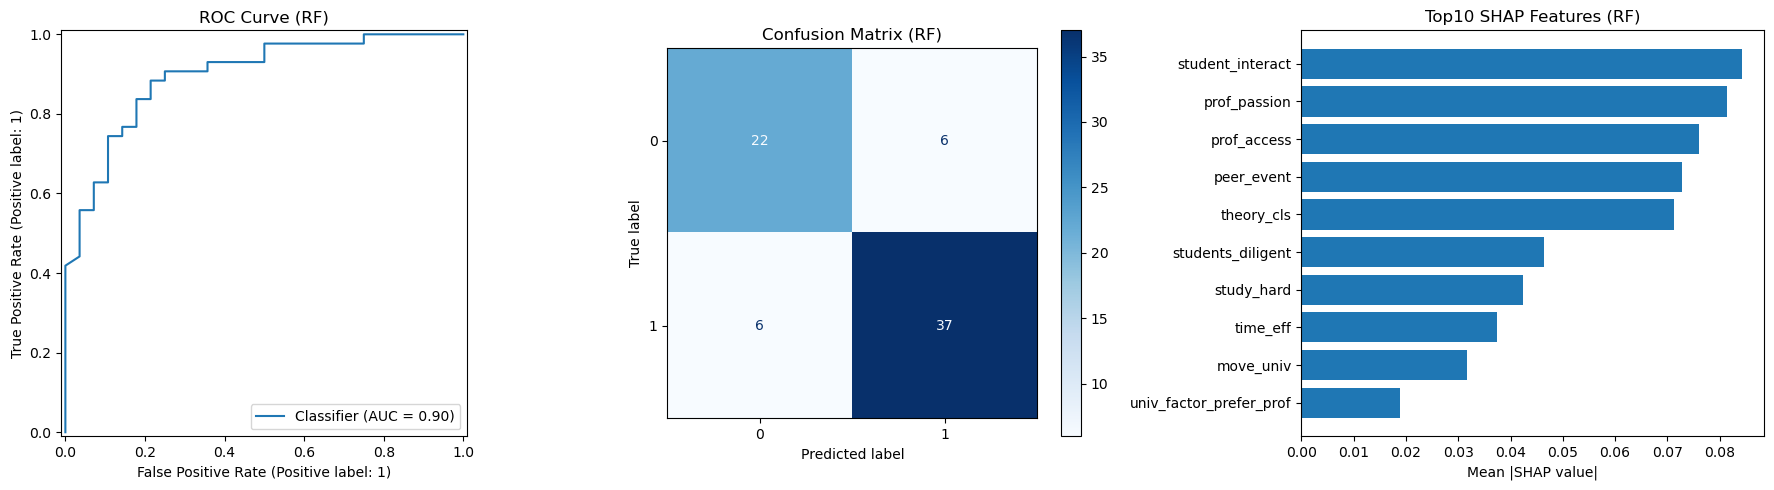


>>> Î∂ÑÏÑù Ï§ë: RFECV_XGB - XGB (n_features=10)
F1 Score: 0.833
Balanced Accuracy: 0.800
ROC AUC: 0.898
Confusion Matrix:
[[22  6]
 [ 8 35]]

Top 10 Features by mean |SHAP|:
                feature  mean_abs_shap
           prof_passion          1.494
             theory_cls          1.289
             peer_event          0.971
            prof_access          0.855
       student_interact          0.846
             study_hard          0.789
               time_eff          0.657
univ_factor_prefer_prof          0.566
      students_diligent          0.510
              move_univ          0.484


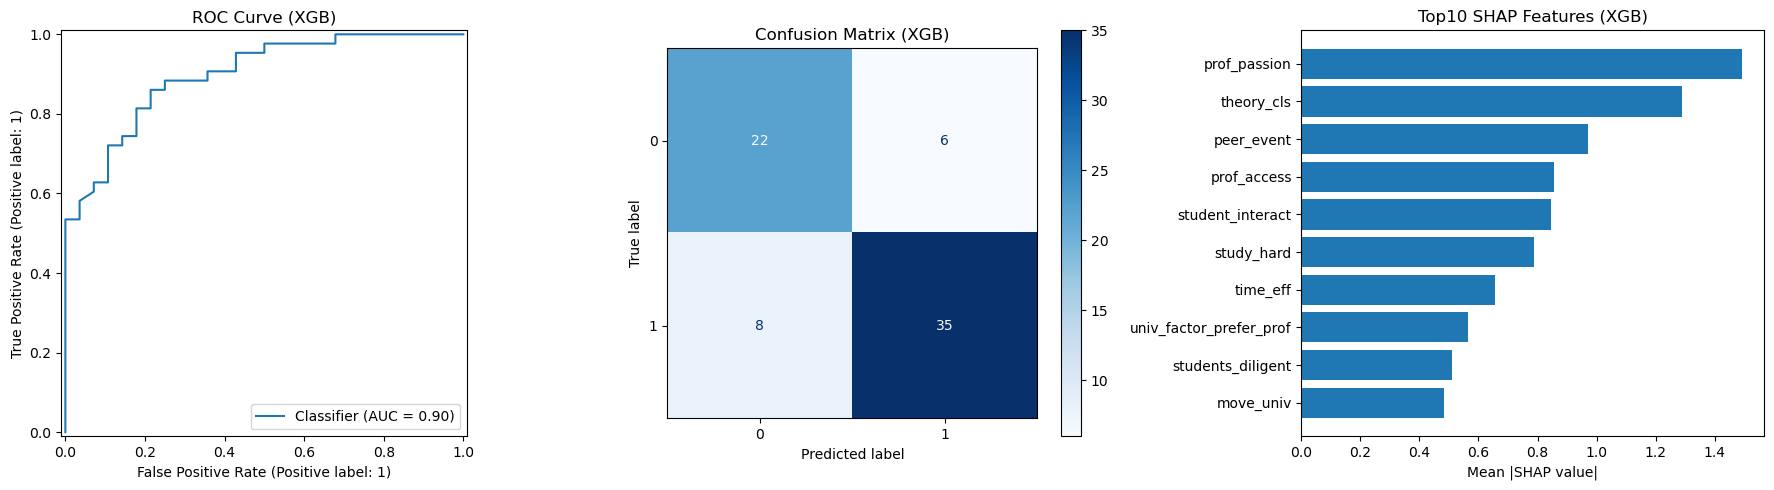


>>> Î∂ÑÏÑù Ï§ë: ElasticNet - RF (n_features=17)
F1 Score: 0.824
Balanced Accuracy: 0.782
ROC AUC: 0.894
Confusion Matrix:
[[21  7]
 [ 8 35]]

Top 10 Features by mean |SHAP|:
          feature  mean_abs_shap
 student_interact          0.063
     prof_passion          0.061
      prof_access          0.060
   course_variety          0.051
       theory_cls          0.047
       peer_event          0.042
students_diligent          0.032
    peer_external          0.030
      know_reason          0.029
       study_hard          0.026


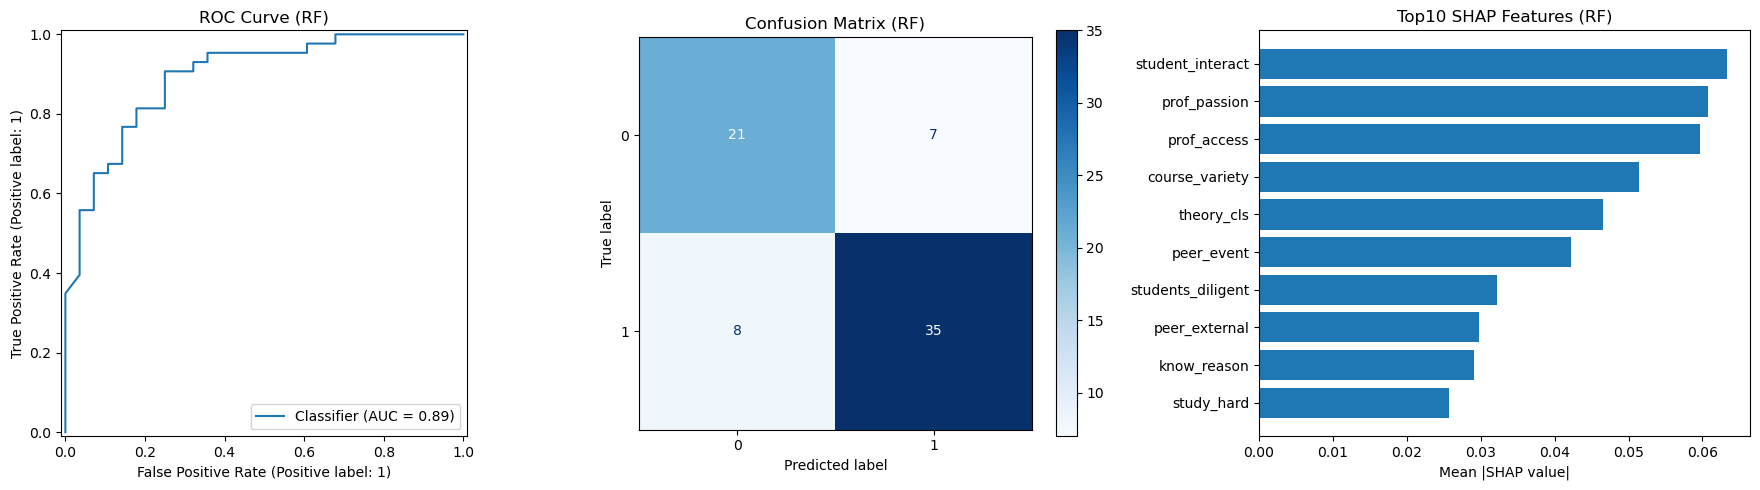


>>> Î∂ÑÏÑù Ï§ë: ElasticNet - LogReg (n_features=17)
F1 Score: 0.805
Balanced Accuracy: 0.777
ROC AUC: 0.875
Confusion Matrix:
[[22  6]
 [10 33]]

Top 10 Features by mean |SHAP|:
          feature  mean_abs_shap
    peer_external          0.461
      support_fac          0.428
       theory_cls          0.417
         try_hard          0.407
         work_fee          0.389
students_diligent          0.383
         time_eff          0.377
     prof_passion          0.311
 student_interact          0.302
       peer_event          0.300

>>> Î∂ÑÏÑù Ï§ë: RFECV_XGB - LogReg (n_features=10)
F1 Score: 0.810
Balanced Accuracy: 0.770
ROC AUC: 0.860
Confusion Matrix:
[[21  7]
 [ 9 34]]

Top 10 Features by mean |SHAP|:
                feature  mean_abs_shap
             peer_event          0.642
             theory_cls          0.542
               time_eff          0.451
       student_interact          0.388
              move_univ          0.362
           prof_passion          0.322
      s

In [142]:
# ======================================
# ‚úÖ Top3 ÏïàÏ†ïÏ†Å Î≥ÄÏàò Í∏∞Î∞ò Î™®Îç∏ Î∂ÑÏÑù Î∞è Top1 ÏÑ†Ï†ï
# (Î≥µÌï© ÏßÄÌëú + Í≥ºÏ†ÅÌï© + Î≥ÄÏàò Ïàò Í≥†Î†§ + ÏïàÏ†ïÏ†Å SHAP Í≥ÑÏÇ∞)
# ======================================

# ------------------------------
# 1Ô∏è‚É£ Î≥µÌï© ÏßÄÌëú Í≥ÑÏÇ∞
# ------------------------------
results_final_df["perf_mean"] = round((
    results_final_df["Test_f1"] +
    results_final_df["Test_roc_auc"] +
    results_final_df["Test_balanced_acc"]
) / 3, 3)

results_final_df["overfit_gap"] = round((
    np.abs(results_final_df["CV_f1_mean"] - results_final_df["Test_f1"]) +
    np.abs(results_final_df["CV_roc_auc_mean"] - results_final_df["Test_roc_auc"]) +
    np.abs(results_final_df["CV_accuracy_mean"] - results_final_df["Test_balanced_acc"])
) / 3, 3)

total_vars = X_train.shape[1]  # Ï†ÑÏ≤¥ Î≥ÄÏàò Ïàò
results_final_df["var_penalty"] = round(results_final_df["n_features"] / total_vars, 3)

results_final_df["composite_score"] = round((
    results_final_df["perf_mean"]
    - 0.5 * results_final_df["overfit_gap"]
    - 0.2 * results_final_df["var_penalty"]
), 3)

# ------------------------------# ------------------------------
# 2Ô∏è‚É£ Top10 Î™®Îç∏ ÏÑ†ÌÉù
# ------------------------------
top10_df = results_final_df.sort_values(by="composite_score", ascending=False).head(10)
top10_df.reset_index(drop=True, inplace=True)

print("\n=== Top10 ÌõÑÎ≥¥ Î™®Îç∏ (Î≥µÌï© ÏßÄÌëú Í∏∞Ï§Ä) ===")
print(top10_df[["source", "model", "n_features",
                "CV_f1_mean", "Test_f1",
                "CV_roc_auc_mean", "Test_roc_auc",
                "CV_accuracy_mean", "Test_balanced_acc",
                "perf_mean", "overfit_gap", "var_penalty", "composite_score"]])


from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# 3Ô∏è‚É£ Top10 Î™®Îç∏ ÌïôÏäµ + ÌèâÍ∞Ä ÏßÄÌëú Ï∂úÎ†• (ÏàòÏπòÎßå)
# ------------------------------
top1_info = None
for idx, row in top10_df.iterrows():
    source = row["source"]
    model_name = row["model"]
    stable_vars = stable_vars_dict[source]
    clf = final_models[model_name]

    print(f"\n>>> Î∂ÑÏÑù Ï§ë: {source} - {model_name} (n_features={len(stable_vars)})")

    # Ï°∞Í±¥Î∂Ä Ïä§ÏºÄÏùºÎßÅ
    if model_name == "LogReg":
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    else:
        pipe = Pipeline([("clf", clf)])

    # ÌïôÏäµ
    pipe.fit(X_train[stable_vars], y_train)
    y_pred = pipe.predict(X_test[stable_vars])
    try:
        y_score = pipe.predict_proba(X_test[stable_vars])[:, 1]
    except:
        y_score = pipe.decision_function(X_test[stable_vars])

    # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
    f1 = f1_score(y_test, y_pred)
    acc = balanced_accuracy_score(y_test, y_pred)
    roc_auc_val = roc_auc_score(y_test, y_score)

    print(f"F1 Score: {f1:.3f}")
    print(f"Balanced Accuracy: {acc:.3f}")
    print(f"ROC AUC: {roc_auc_val:.3f}")

    # ÌòºÎèôÌñâÎ†¨ (ÏàòÏπò)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # SHAP Í≥ÑÏÇ∞
    if model_name in ["RF", "XGB"]:
        explainer = shap.TreeExplainer(pipe.named_steps['clf'])
        shap_values = explainer.shap_values(X_test[stable_vars])
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    elif model_name in ["LogReg", "ElasticNet"]:
        explainer = shap.LinearExplainer(pipe.named_steps['clf'], X_train[stable_vars])
        shap_values = explainer.shap_values(X_test[stable_vars])
    else:
        explainer = shap.Explainer(pipe.named_steps['clf'], X_train[stable_vars])
        shap_values = explainer(X_test[stable_vars]).values

    shap_values_arr = np.array(shap_values)
    if shap_values_arr.ndim > 2:
        shap_values_arr = shap_values_arr[:, :, 0]
    mean_abs_shap = np.abs(shap_values_arr).mean(axis=0)

    shap_df = pd.DataFrame({
        "feature": stable_vars,
        "mean_abs_shap": mean_abs_shap
    }).sort_values(by="mean_abs_shap", ascending=False).head(10)

    print("\nTop 10 Features by mean |SHAP|:")
    print(shap_df.to_string(index=False))

    # ===============================
    # ‚úÖ Top3 Î™®Îç∏Îßå ÏãúÍ∞ÅÌôî Ï∂îÍ∞Ä
    # ===============================
    if idx < 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # ROC Curve
        RocCurveDisplay.from_predictions(y_test, y_score, ax=axes[0])
        axes[0].set_title(f"ROC Curve ({model_name})")

        # Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[1], cmap="Blues")
        axes[1].set_title(f"Confusion Matrix ({model_name})")

        # SHAP Bar Plot
        axes[2].barh(shap_df["feature"], shap_df["mean_abs_shap"])
        axes[2].invert_yaxis()
        axes[2].set_title(f"Top10 SHAP Features ({model_name})")
        axes[2].set_xlabel("Mean |SHAP value|")

        plt.tight_layout()
        plt.show()

    # Top1 ÏµúÏ¢Ö ÏÑ†Ï†ï
    if idx == 0:
        top1_info = {
            "source": source,
            "model_name": model_name,
            "stable_vars": stable_vars,
            "pipeline": pipe,
            "y_pred": y_pred,
            "y_score": y_score,
            "shap_df": shap_df
        }


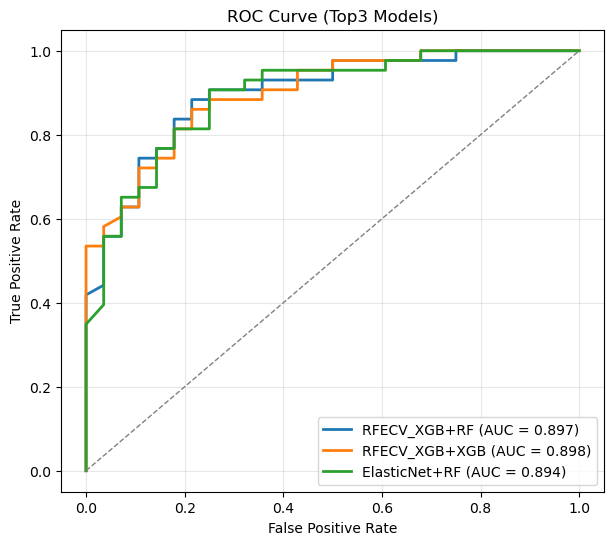

In [144]:
# ------------------------------
# ‚úÖ Top3 ROC Curve Ìïú Í∑∏ÎûòÌîÑÏóê Í∑∏Î¶¨Í∏∞
# ------------------------------
plt.figure(figsize=(7, 6))

for idx, row in top10_df.head(3).iterrows():
    source = row["source"]
    model_name = row["model"]
    stable_vars = stable_vars_dict[source]
    clf = final_models[model_name]

    # Ï°∞Í±¥Î∂Ä Ïä§ÏºÄÏùºÎßÅ
    if model_name == "LogReg":
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    else:
        pipe = Pipeline([("clf", clf)])

    pipe.fit(X_train[stable_vars], y_train)

    try:
        y_score = pipe.predict_proba(X_test[stable_vars])[:, 1]
    except:
        y_score = pipe.decision_function(X_test[stable_vars])

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # üîë labelÏóê source+model_name Í∞ôÏù¥ ÌëúÏãú
    plt.plot(
        fpr, tpr, lw=2,
        label=f"{source}+{model_name} (AUC = {roc_auc:.3f})"
    )

# ÎûúÎç§ Í∏∞Ï§ÄÏÑ†
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Top3 Models)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [156]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Î≤îÏ£ºÌòï Î≥ÄÏàò ÍµêÏ∞®Ìëú
contingency_table = pd.crosstab(df['sat_group'], df['univ_factor_prefer_prof'])
contingency_table.loc['Ìï©Í≥Ñ'] = contingency_table.sum()

# ÏàòÏπòÌòï Î≥ÄÏàò ÌèâÍ∑† ¬± ÌëúÏ§ÄÌé∏Ï∞® Í≥ÑÏÇ∞ Î∞è t-Í≤ÄÏ†ï
num_vars = ['move_univ', 'peer_event', 'prof_access', 'prof_passion',
            'student_interact', 'students_diligent', 'study_hard',
            'theory_cls', 'time_eff']

summary_list = []
for var in num_vars:
    low_vals = df[df['sat_group']==0][var]
    high_vals = df[df['sat_group']==1][var]
    mean_std_low = f"{low_vals.mean():.3f} ¬± {low_vals.std():.3f}"
    mean_std_high = f"{high_vals.mean():.3f} ¬± {high_vals.std():.3f}"
    t_stat, p_val = ttest_ind(low_vals, high_vals, equal_var=False)
    summary_list.append([var, mean_std_low, mean_std_high, round(t_stat, 3), round(p_val, 3)])

# Î≤îÏ£ºÌòï Î≥ÄÏàò Ïπ¥Ïù¥Í≤ÄÏ†ï
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table.iloc[:-1, :])

summary_df = pd.DataFrame(summary_list, columns=[
    "Variable", "Low Satisfaction Mean ¬± Std", "High Satisfaction Mean ¬± Std", "t", "p-value"
])

# prefer_prof ÎπàÎèÑ Î∞è Ïπ¥Ïù¥Í≤ÄÏ†ï Í≤∞Í≥º Ï∂îÍ∞Ä
prefer_prof_freq = pd.DataFrame({
    'Variable': ['prefer_prof (freq)'],
    'Low Satisfaction Mean ¬± Std': [''],
    'High Satisfaction Mean ¬± Std': [''],
    't': [round(chi2_stat, 3)],
    'p-value': [round(chi2_p, 3)],
    'prefer_prof=0': [contingency_table.loc[0, 0]],
    'prefer_prof=1': [contingency_table.loc[0, 1]],
    'Ìï©Í≥Ñ': [contingency_table.loc['Ìï©Í≥Ñ', :].sum()]
})

# ÏµúÏ¢Ö Ìëú Í≤∞Ìï©
final_df = final_df.sort_values(by="p-value", ascending=True)


print(final_df)


             Variable Low Satisfaction Mean ¬± Std  \
0           move_univ               2.200 ¬± 1.177   
1          peer_event               3.171 ¬± 1.112   
2         prof_access               3.343 ¬± 0.935   
3        prof_passion               3.593 ¬± 0.813   
4    student_interact               3.486 ¬± 0.861   
5   students_diligent               3.400 ¬± 0.838   
6          study_hard               3.600 ¬± 0.958   
7          theory_cls               3.121 ¬± 0.940   
8            time_eff               3.086 ¬± 0.933   
9  prefer_prof (freq)                               

  High Satisfaction Mean ¬± Std       t  p-value  prefer_prof=0  prefer_prof=1  \
0                1.577 ¬± 0.923   5.295    0.000            NaN            NaN   
1                4.228 ¬± 0.875  -9.490    0.000            NaN            NaN   
2                4.293 ¬± 0.775  -9.994    0.000            NaN            NaN   
3                4.493 ¬± 0.595 -11.285    0.000            NaN            NaN

In [134]:
# Ï†ÑÏ≤¥ Î≥ÄÏàò Î™©Î°ù Ï∂úÎ†•
all_features = X_train.columns.tolist()
print(all_features)

# Î≥ÄÏàò Í∞úÏàò ÌôïÏù∏
print("Ï†ÑÏ≤¥ Î≥ÄÏàò Í∞úÏàò:", len(all_features))


['univ_rank', 'major_rank', 'know_reason', 'prof_exp', 'study_hard', 'time_eff', 'edu_doubt', 'learn_fun', 'study_mate', 'try_hard', 'write_vol', 'find_data', 'self_study', 'try_fail', 'get_fdbk', 'real_appl', 'ask_q', 'fit_major', 'cont_major', 'rechoice_major', 'move_univ', 'change_major', 'change_career', 'take_leave', 'drop_out', 'go_abroad', 'go_grad', 'work_fee', 'has_future_job', 'has_income', 'has_major_income', 'smoke_exp', 'drink_freq', 'exercise_reg', 'burnout', 'mental_health', 'physical_health', 'housing_infra', 'housing_transit', 'housing_safety', 'housing_hygiene', 'housing_green', 'housing_culture', 'housing_edu', 'housing_neighbor', 'move_for_univ', 'stay_after', 'lecture_fac', 'support_fac', 'scholarship', 'tuition', 'transport', 'prac_cls', 'theory_cls', 'prof_effort', 'admin_serv', 'car_spt', 'intern_abroad', 'career_course', 'career_mentoring', 'job_test', 'job_prep', 'field_practice', 'abroad_practice', 'job_info', 'job_fair', 'prof_class_talk', 'prof_other_talk',

______________________________________#################

In [157]:
# ======================================
# ElasticNet(LogisticRegressionCV) ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌôïÏù∏
# ======================================

# 1) ÌååÏù¥ÌîÑÎùºÏù∏ ÌïôÏäµ
enet_pipeline.fit(X_train, y_train)

# 2) ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌôïÏù∏
best_Cs = enet_pipeline.named_steps['clf'].C_       # foldÎ≥Ñ ÏµúÏ†Å C Í∞í (Î∞∞Ïó¥)
best_l1  = enet_pipeline.named_steps['clf'].l1_ratio_  # ÏµúÏ†Å l1_ratio (Î∞∞Ïó¥)

print("ElasticNet ÏµúÏ†Å C Í∞í (foldÎ≥Ñ):", best_Cs)
print("ElasticNet ÏµúÏ†Å l1_ratio (foldÎ≥Ñ):", best_l1)


ElasticNet ÏµúÏ†Å C Í∞í (foldÎ≥Ñ): [0.04641589]
ElasticNet ÏµúÏ†Å l1_ratio (foldÎ≥Ñ): [0.1]


# Ïó¨Í∏∞Î∂ÄÌÑ∞ Îã§Ïãú 

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------
# 1Ô∏è‚É£ Hold-out + CV ÌèâÍ∑† + ÏïàÏ†ïÏ†Å Î≥ÄÏàò Ïàò Îì± Í≥†Î†§Ìï¥ÏÑú Top5 ÏÑ†Ï†ï
# ---------------------------------
df_res = results_final_df.copy()

# CV-Test F1 gap Í≥ÑÏÇ∞
df_res['CV-Test_F1_gap'] = df_res['CV_f1_mean'] - df_res['Test_f1']

# Ï¢ÖÌï© Ï†êÏàò: Hold-out F1, Balanced Accuracy, MCC, ROC-AUC ÌèâÍ∑†ÏóêÏÑú CV-Test gap Ìå®ÎÑêÌã∞
df_res['score_combined'] = df_res[['Test_f1', 'Test_balanced_acc', 'Test_mcc', 'Test_roc_auc']].mean(axis=1) - df_res['CV-Test_F1_gap'].abs()

# Top5 ÏÑ†Ï†ï
top5_df = df_res.sort_values(by='score_combined', ascending=False).head(5).reset_index(drop=True)

# ÏÜåÏàòÏ†ê 3ÏûêÎ¶¨ Î∞òÏò¨Î¶º (Ï°¥Ïû¨ÌïòÎäî Ïª¨ÎüºÎßå)
num_cols = ['CV_f1_mean', 'CV_roc_auc_mean', 'Test_f1', 'Test_balanced_acc', 'Test_mcc', 'Test_roc_auc', 'score_combined', 'CV-Test_F1_gap']
num_cols = [c for c in num_cols if c in top5_df.columns]
top5_df[num_cols] = top5_df[num_cols].round(3)

# Í≤∞Í≥º Ï∂úÎ†•
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("=== ÏïàÏ†ïÏ†Å Î≥ÄÏàò Í∏∞Î∞ò Î™®Îç∏ Top5 (Hold-out Ï§ëÏã¨, CV/ÏïàÏ†ïÏÑ± Í≥†Î†§) ===")
display(top5_df[['source', 'model', 'n_features'] + num_cols])


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1Ô∏è‚É£ RFECV_XGBÏùò ÏïàÏ†ïÏ†Å Î≥ÄÏàò Î∂àÎü¨Ïò§Í∏∞
stable_vars_xgb = stable_vars_dict["RFECV_XGB"]

# 2Ô∏è‚É£ RandomForest ÌïôÏäµ (source=RFECV_XGB, model=RF)
rf_clf = RandomForestClassifier(
    n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1
)

rf_clf.fit(X_train[stable_vars_xgb], y_train)

# 3Ô∏è‚É£ ÏòàÏ∏°
y_pred_rf = rf_clf.predict(X_test[stable_vars_xgb])

# 4Ô∏è‚É£ Confusion Matrix Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

print("=== Confusion Matrix (RFECV_XGB + RF) ===")
print(cm)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: RFECV_XGB + RF")
plt.show()


In [ ]:
# enet, rfecv(rf) ÏïàÏ†ïÏ†Å Î≥ÄÏàò Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌôïÏù∏

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# -------------------------------
# ÏïàÏ†ïÏ†Å Î≥ÄÏàò Î¶¨Ïä§Ìä∏
# -------------------------------
enet_vars = [
    "course_variety", "know_reason", "move_univ", "peer_advice", "peer_event",
    "peer_external", "prof_access", "prof_event", "prof_passion", "student_interact",
    "students_diligent", "study_hard", "support_fac", "theory_cls", "time_eff",
    "try_hard", "work_fee"
]

rf_vars = [
    "admin_serv", "ask_q", "birth_area_chungcheong", "burnout", "car_spt", "change_career", "change_major",
    "cont_major", "course_variety", "dance_years", "drink_freq", "drop_out", "edu_doubt", "exercise_reg", 
    "exp_concours", "exp_group_comp", "exp_solo_comp", "find_data", "fit_major", "get_fdbk", "go_abroad", "go_grad", "grade",
    "housing_culture", "housing_edu", "housing_green", "housing_hygiene", "housing_infra", "housing_neighbor", "housing_safety",
    "housing_transit", "housing_type_parents", "intern_abroad", "job_test", "know_reason", "learn_fun", "lecture_fac", "mental_health",
    "move_univ", "peer_advice", "peer_career", "peer_class", "peer_event", "peer_external", "physical_health", "prac_cls",
    "prof_access", "prof_career", "prof_class_talk", "prof_effort", "prof_event", "prof_exp", "prof_grade", "prof_other_talk",
    "prof_passion", "prof_personal", "real_appl", "scholarship", "self_study", "smoke_exp", "stay_after", "student_interact", 
    "students_diligent", "study_hard", "study_mate", "support_fac", "take_leave", "theory_cls", "time_eff", "transport", "try_fail",
    "try_hard", "tuition", "univ_course_year", "univ_factor_prefer_prof", "univ_factor_social_reputation", "univ_name_bau",
    "univ_name_swu", "univ_rank", "work_fee", "write_vol"

]

xgb_vars = ["move_univ", "peer_event", "prof_access", "prof_passion", "student_interact", "students_diligent",
    "study_hard", "theory_cls", "time_eff", "univ_factor_prefer_prof"]

# -------------------------------
# ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
# -------------------------------
enet_corr = X_train[enet_vars].corr()
rf_corr = X_train[rf_vars].corr()
xgb_corr = X_train[xgb_vars].corr()

print("=== ElasticNet ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ===")
display(enet_corr)

print("=== RFECV(Random Forest) ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ===")
display(rf_corr)

print("=== RFECV(XGBoost) ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ===")
display(xgb_corr)
# -------------------------------
# VIF Í≥ÑÏÇ∞ Ìï®Ïàò
# -------------------------------
def compute_vif(df):
    # ÌëúÏ§ÄÌôî
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
    vif_data = pd.DataFrame()
    vif_data["variable"] = X_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
    return vif_data

enet_vif = compute_vif(X_train[enet_vars])
rf_vif = compute_vif(X_train[rf_vars])
xgb_vif = compute_vif(X_train[xgb_vars])
print("=== ElasticNet ÏïàÏ†ïÏ†Å Î≥ÄÏàò VIF ===")
display(enet_vif.sort_values("VIF", ascending=False))

print("=== RFECV(Random Forest) ÏïàÏ†ïÏ†Å Î≥ÄÏàò VIF ===")
display(rf_vif.sort_values("VIF", ascending=False))

print("=== RFECV(XGBoost) ÏïàÏ†ïÏ†Å Î≥ÄÏàò VIF ===")
display(xgb_vif.sort_values("VIF", ascending=False))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# ElasticNet ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ
# -------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(enet_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            square=True, linewidths=0.5, linecolor='gray')
plt.title("ElasticNet ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ")
plt.show()

# -------------------------------
# RFECV(Random Forest) ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ
# -------------------------------
plt.figure(figsize=(16,14))
sns.heatmap(rf_corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("RFECV(RF) ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò (Í∏ÄÏûê ÌöåÏ†Ñ, annot=False)")
plt.show()

# -------------------------------
# RFECV(XGBOOST) ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ 
# -------------------------------
plt.figure(figsize=(10,8))
sns.heatmap(xgb_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='gray', square=True)
plt.title("RFECV(XGB) ÏïàÏ†ïÏ†Å Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ")
plt.show()



# 4. ÏÉÅÏúÑ 5Í∞ú Î™®Îç∏ ÏÉÅÏÑ∏ ÏÑ±Îä•

In [ ]:
# Top 5 Î™®Îç∏ ÏÑ†Ï†ï
df_res["score_combined"] = df_res[["Test_f1", "Test_balanced_acc", "Test_mcc", "Test_roc_auc"]].mean(axis=1) - df_res["CV-Test_F1_gap"].abs()
top5_models = df_res.sort_values(by="score_combined", ascending=False).head(5)

print("=== Ï¢ÖÌï© Í∏∞Ï§Ä Top 5 Î™®Îç∏ ===")
display(top5_models[["model", "Test_f1", "Test_balanced_acc", "Test_mcc", "score_combined", "CV-Test_F1_gap", "Test_roc_auc"]])


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, info in top_models.items():
    X_sel = X_test[info['vars']]
    model = info['model']

    # ÌïôÏäµ (Ï†ÑÏ≤¥ train)
    if isinstance(model, LogisticRegression):
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    else:
        pipe = Pipeline([('clf', model)])
    pipe.fit(X_train[info['vars']], y_train)

    # predict_proba
    try:
        y_score = pipe.predict_proba(X_sel)[:,1]
    except:
        y_score = pipe.decision_function(X_sel)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Top5 Models ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# 5 ÏµúÏ†Å Î™®Îç∏ SHAP Î≥ÄÏàò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞

In [ ]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# ---------------------------------
# 1Ô∏è‚É£ Îã®Ïùº ÌõàÎ†® Í∏∞Î∞ò SHAP
# ---------------------------------
mask = fitted_pipe.named_steps['feature_selection'].support_
X_train_sel = X_train.loc[:, mask]
xgb_model = fitted_pipe.named_steps['clf']

explainer = shap.TreeExplainer(xgb_model)
X_shap = X_train_sel.sample(n=min(2000, len(X_train_sel)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_shap)

shap_df_train = pd.DataFrame({
    "feature": X_train_sel.columns,
    "shap_mean_abs": np.abs(shap_values).mean(axis=0),
    "shap_mean": shap_values.mean(axis=0)
}).sort_values(by="shap_mean_abs", ascending=False).reset_index(drop=True)

# ÏÜåÏàòÏ†ê 3ÏûêÎ¶¨ Î∞òÏò¨Î¶º
shap_df_train[["shap_mean_abs", "shap_mean"]] = shap_df_train[["shap_mean_abs", "shap_mean"]].round(3)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

display(shap_df_train)



# 6 ÏµúÏ†Å Î™®Îç∏ SHAP Î∞è ROC ÏãúÍ∞ÅÌôî

In [ ]:
import shap
import matplotlib.pyplot as plt

# ---------------------------------
# 1Ô∏è‚É£ SHAP Summary Plot (Dot plot)
# ---------------------------------
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sel)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sel, plot_type="dot", show=True)

# ---------------------------------
# 2Ô∏è‚É£ SHAP Bar Plot (Feature importance based on mean(|SHAP|))
# ---------------------------------
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sel, plot_type="bar", show=True)


In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sel)

# Dot plot: Ï†ÑÏ≤¥ Î≥ÄÏàò ÌëúÏãú
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sel, plot_type="dot", max_display=len(X_train_sel.columns), show=True)

# Bar plot: Ï†ÑÏ≤¥ Î≥ÄÏàò ÌëúÏãú
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sel, plot_type="bar", max_display=len(X_train_sel.columns), show=True)


# Í∏∞Ïà†ÌÜµÍ≥Ñ Îì± EDA 

In [ ]:
import pandas as pd

# 1. Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞
df_all = X.copy()
df_all['target'] = y

# 2. 1ÏßëÎã®Í≥º 0ÏßëÎã® Î∂ÑÎ¶¨
group1 = df_all[df_all['target'] == 1]
group0 = df_all[df_all['target'] == 0]

# 3. Î≥ÄÏàòÎ≥Ñ ÏöîÏïΩ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
summary_list = []
for col in X.columns:
    summary_list.append({
        'variable': col,
        'mean_all': df_all[col].mean(),
        'std_all': df_all[col].std(),
        'n_all': df_all[col].count(),
        'mean_1': group1[col].mean(),
        'std_1': group1[col].std(),
        'n_1': group1[col].count(),
        'mean_0': group0[col].mean(),
        'std_0': group0[col].std(),
        'n_0': group0[col].count()
    })

summary_df = pd.DataFrame(summary_list)

# ÏÜåÏà´Ï†ê ÎëòÏß∏ÏûêÎ¶¨ÍπåÏßÄ Î∞òÏò¨Î¶º
summary_df = summary_df.round(2)

display(summary_df)


In [ ]:
# ÏàòÏπòÌòï Î≥ÄÏàò tÍ≤ÄÏ†ï 
import pandas as pd
from scipy.stats import ttest_ind

# -------------------------
# target Ìè¨Ìï® df_all
# -------------------------
df_all = df.copy()
df_all["target"] = df_all["sat_group"]

# -------------------------
# ÏõêÌï´Ïù∏ÏΩîÎî©Îêú Ïª¨Îüº Ìå®ÌÑ¥ (Î≤îÏ£ºÌòï)
# -------------------------
cat_prefixes = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]

# -------------------------
# Ïù¥ÏßÑÌòï Î≥ÄÏàò
# -------------------------
bin_vars = [
    'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'exp_perf', 'exp_video', 'exp_broadcast',
    'gender','career_course', 'career_mentoring', 'job_test', 'job_prep',
    'field_practice', 'abroad_practice', 'job_info', 'job_fair',
    'move_for_univ', 'stay_after', 'has_future_job', 'has_income',
    'has_major_income', 'rechoice_major' ,'burnout'
]

# -------------------------
# ÏàòÏπòÌòï Î≥ÄÏàò Î™©Î°ù (ÏõêÌï´, Ïù¥ÏßÑ Î≥ÄÏàò Ï†úÏô∏)
# -------------------------
numeric_vars = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_vars = [col for col in numeric_vars if col not in ["sat", "sat_group"]]
numeric_vars = [
    col for col in numeric_vars
    if not any(col.startswith(prefix + "_") for prefix in cat_prefixes)
    and col not in bin_vars
]

# -------------------------
# t-test ÏàòÌñâ Î∞è p-value Îì±Í∏â, ÏßëÎã®Î≥Ñ mean(std) Ï∂îÍ∞Ä
# -------------------------
ttest_results = []

for col in numeric_vars:
    group0 = df_all[df_all["target"]==0][col]
    group1 = df_all[df_all["target"]==1][col]
    
    # ÎèÖÎ¶ΩÌëúÎ≥∏ t-test (Îì±Î∂ÑÏÇ∞ Í∞ÄÏ†ï=False)
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
    
    # Ïú†Ïùò ÏàòÏ§Ä ÌôïÏù∏
    if p_val < 0.001:
        p_level = "<0.001"
    elif p_val < 0.01:
        p_level = "<0.01"
    elif p_val < 0.05:
        p_level = "<0.05"
    else:
        continue  # p >= 0.05Ïù¥Î©¥ Í≤∞Í≥ºÏóêÏÑú Ï†úÏô∏
    
    ttest_results.append({
        "variable": col,
        "t_stat": round(t_stat, 3),
        "p_value": round(p_val, 6),
        "p_level": p_level,
        "mean_group0": f"{group0.mean():.2f} ({group0.std():.2f})",
        "mean_group1": f"{group1.mean():.2f} ({group1.std():.2f})"
    })

# -------------------------
# Í≤∞Í≥º DataFrame (p-value Í∏∞Ï§Ä Ï†ïÎ†¨)
# -------------------------
ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values("p_value").reset_index(drop=True)

print(ttest_df)


In [ ]:
print("ÏàòÏπòÌòï Î≥ÄÏàò Í∞úÏàò:", len(numeric_vars))
print("ÏàòÏπòÌòï Î≥ÄÏàò Î™©Î°ù:", numeric_vars)


In [ ]:
# Î≤îÏ£ºÌòï Î≥ÄÏàò Ïπ¥Ïù¥Í≤ÄÏ†ï 
import pandas as pd
from scipy.stats import chi2_contingency

df_all = df.copy()
df_all["target"] = df_all["sat_group"]

cat_prefixes = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]

bin_vars = [
    'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'gender',
    'career_course', 'career_mentoring', 'job_test', 'job_prep',
    'field_practice', 'abroad_practice', 'job_info', 'job_fair',
    'move_for_univ', 'stay_after', 'has_future_job', 'has_income',
    'has_major_income', 'rechoice_major','burnout','exp_perf', 'exp_video', 'exp_broadcast'
]

chi_results = []

# Ìï®Ïàò: ÍµêÏ∞®Ìëú + Ìñâ Í∏∞Ï§Ä ÎπÑÏú® + Ï†ÑÏ≤¥ ÎåÄÎπÑ ÎπÑÏú® + chi2
def process_variable(var_name, df, target="target"):
    crosstab = pd.crosstab(df[var_name], df[target])
    row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    total_pct = crosstab.div(len(df)) * 100
    display_table = crosstab.astype(str) + " (" + row_pct.round(1).astype(str) + "% / " + total_pct.round(1).astype(str) + "%)"
    
    print(f"\n=== {var_name} vs ÎßåÏ°±ÎèÑ ===")
    print(display_table)
    
    if crosstab.shape[0] > 1:
        chi2, p, dof, expected = chi2_contingency(crosstab)
        print(f"\n>>> {var_name} Ïπ¥Ïù¥Ï†úÍ≥± Í≤ÄÏ†ï Í≤∞Í≥º: chi2={chi2:.3f}, df={dof}, p={p:.6f} ({'Ïú†Ïùò' if p < 0.05 else 'ÎπÑÏú†Ïùò'})")
        chi_results.append({
            "variable": var_name,
            "chi2": round(chi2, 3),
            "dof": dof,
            "p_value": round(p, 6),
            "significant": "Ïú†Ïùò" if p < 0.05 else "ÎπÑÏú†Ïùò"
        })

# Î≤îÏ£ºÌòï Î≥ÄÏàò Ï≤òÎ¶¨
for prefix in cat_prefixes:
    cols = [c for c in df_all.columns if c.startswith(prefix + "_")]
    if not cols:
        continue

    df_all[cols] = df_all[cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    df_all[f"{prefix}_raw"] = df_all[cols].idxmax(axis=1).str.replace(prefix + "_", "")
    process_variable(f"{prefix}_raw", df_all)

# Ïù¥ÏßÑÌòï Î≥ÄÏàò Ï≤òÎ¶¨
for col in bin_vars:
    if col not in df_all.columns:
        continue
    process_variable(col, df_all)

# Ïπ¥Ïù¥Ï†úÍ≥± ÏöîÏïΩ
chi_df = pd.DataFrame(chi_results).sort_values(by="p_value").reset_index(drop=True)
print("\n=== Ïπ¥Ïù¥Ï†úÍ≥± Í≤∞Í≥º ÏöîÏïΩ (p-value Í∏∞Ï§Ä Ï†ïÎ†¨) ===")
print(chi_df)


In [ ]:
# cat_prefixes ÏõêÌï´ ‚Üí Îã®ÏùºÍ∞íÏúºÎ°ú Î≥µÏõê
categorical_vars_raw = [f"{prefix}_raw" for prefix in cat_prefixes]

# bin_vars Í∑∏ÎåÄÎ°ú
categorical_vars_bin = [col for col in bin_vars if col in df_all.columns]

# Ï†ÑÏ≤¥ Î≤îÏ£ºÌòï Î≥ÄÏàò Î™©Î°ù
categorical_vars_all = categorical_vars_raw + categorical_vars_bin

print("Î≤îÏ£ºÌòï Î≥ÄÏàò Í∞úÏàò:", len(categorical_vars_all))
print("Î≤îÏ£ºÌòï Î≥ÄÏàò Î™©Î°ù:", categorical_vars_all)


In [ ]:
# Ï†ÑÏ≤òÎ¶¨ ÌõÑ ÏµúÏ¢Ö Î≥ÄÏàò Î™©Î°ù
final_vars = df.columns.tolist()
print("Ï¥ù Î≥ÄÏàò Ïàò:", len(final_vars))
print("Î≥ÄÏàò Î™©Î°ù:")
for var in final_vars:
    print(var)
